# CS421 Project
---

Group: Empirical Risk Minimisers  
Members:
- Lai Wan Xuan Joanne (joanne.lai.2021)
- Ryan Miguel Moralde Sia (ryansia.2022)
- Dhruv Benegal (benegalda.2022)
- Benedict Lee Zi Le (benedictlee.2022)

In this notebook, we train our models on the four batches of data provided, and produce predictions on the fifth and final batch of data.

### 1. Background & Objective

In this project, you will be working with data extracted from famous recommender systems type datasets: you are provided with a large set of interactions between users (persons) and items (movies). Whenever a user "interacts" with an item, it watches the movie and gives a "rating". There are 5 possible ratings expressed as a "number of stars": 1,2,3,4, or 5. 

In this exercise, we will **not** be performing the recommendation task per se. Instead, you will try to identify the amount of noise/corruption which was injected in each user. Indeed, for each of the users you have been given, an anomaly/noise generation procedure was applied to corrupt the sample. The noise generation procedure depends on two variables: the noise level $p\in [0,1]$ and the noise type $X\in\{0,1,2\}$.  Each user has been randomly assigned a noise level $p$ and anomaly/noise type $X$, and subsequently been corrupted with the associated noise generation procedure. 

You have two tasks: first, you must predict the noise level $p$ associated to each test user. This is a **supervised regression task**. Second, you must try to identify the noise generation type for each user. This is a classification task with three classes, with the possibility of including more classes later depending on class performance. This task will be semi-supervised: only a very small number of labels is provided. You will therefore need to combine supervised and unsupervised approaches for this component. 

### 2. Data

You are provided with three frames: the first one ("X") contains the interactions provided to you, and the second one ("yy") contains the continuous for the users. The third data frame "yy_cat" contains the anomaly/noise type for 15 users. The idea is to use these users to disambiguate the category types, but the task will mostly be unsupervised. 

As you can see, the three columns in "X" correspond to the user ID, the item ID and the rating (encoded into numerical form). Thus, each row of "X" contains a single interaction. For instance, if the row "$142, 152, 5$" is present, this means that the user with ID $142$ has given the movie $152$ a positive rating of $5$.

The dataframe "yy" has two columns. In the first column we have the user IDs, whilst the second column contains the continuous label. A label of $0.01$ indicates a very low anomaly level, whilst a label of $0.99$ indicates a very high amount of noise/corruption. 

### 3. Evaluation

Your task is to be able to regress the noise level $p$ for each new user, and predict the anomaly type $X$. The first (regression) task will be easier due to the larger amount of supervision, and will form the main basis of the evaluation. The second task will be more importance to showcase each team's creativity and differentiate between top performers. 

THE **EVALUATION METRICs** are:  

1. The Mean Absolute Error (MAE) for the regression task. 
2. The accuracy for the classiciation task. 

Every few weeks, we will evaluate the performance of each team (on a *test set with unseen labels* that I will provide) in terms of both metrics

The difficulty implied by **the generation procedure of the anomalies MAY CHANGE as the project evolves: depending on how well the teams are doing, I may generate easier or harder anomaly classes, which would change the number of labels in the classification task**. However, the regression task will still be the same (with a different distribution).

### 4. Deliverables

Together with this file, you are provided with a first batch of examples "`first_batch_regression_labelled.npz`" which are labelled in terms of noise level. You are also provided with the test samples to rank by the next round (without labels) in the file "`second_batch_regression_unlabelled.npz`".

The **first round** will take place after recess (week 9): you must hand in your scores for the second batch before the **Wednesday at NOON (15th of October)**. We will then look at the results together on the Friday.  

We will check everyone's performance in this way every week (once on  week 10, once on week 11 and once on week 12). 

---

To summarise, the project deliverables are as follows:

- Before every checkpoint's deadline, you need to submit **a `.csv` file** containing a dataframe of size $\text{number of test batch users} \times 3$.
    - The first column should be the user IDs of the test batch.
    - The second column should contain the estimated noise level $p$ for each sample.
    - The final column should contain the estimated class (it should be a natural number in \{0,1,2\}).
- The order of rows should correspond to the user IDs. For example, if the test batch contains users 1100-2200, scores for user 1100 should be the first row (row 0), scores for user 1101 should be the second row (row 1), and so on.
- On Week 12-13 (schedule to be decided), you need to present your work in class. The presentation duration is **10 minutes** with 5 minutes of QA.
- On Week 12, you need to submit your **Jupyter Notebook** (with comments in Markdown) and the **slides** for your presentation. 
- On week 13 you need to submit your **final report**. The final report should be 2-3 pages long (consisting of problem statement, literature review, and motivation of algorithm design) with unlimited references/appendix.

Whilst performance (expressed in terms of MAE and accuracy) at **each of the check points** (weeks 9 to 12 inclusive) is an **important component** of your **final grade**, the **final report** and the detail of the various methods you will have tried will **also** be very **important**. Ideally, to get perfect marks (A+), you should try at least **two supervised methods** and **two unsupervised methods**, as well as be ranked the **best team** in terms of performance. 


In addition, I will be especially interested in your **reasoning**. Especially high marks will be awarded to any team that is able to **qualitatively describe** the difference between the two anomaly types. You are also encouraged to compute statistics related to each class and describe what is different about them. 

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (
    kurtosis,
    skew,
    entropy
)
from sklearn.decomposition import (
    PCA,
    TruncatedSVD
)
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    Ridge,
    Lasso,
    SGDRegressor
    )
from sklearn.tree import (
    DecisionTreeRegressor
)
from sklearn.ensemble import (
    RandomForestRegressor,
    BaggingRegressor
)
from sklearn.metrics import (
    mean_absolute_error,
    accuracy_score
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.cluster import KMeans
from sklearn.ensemble import StackingRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.semi_supervised import LabelSpreading

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

%matplotlib inline

## Data Loading and Cleaning

### Data Loading

In [2]:
# Load the data
first_batch  = np.load("data/Week1/first_batch_regression_labelled.npz")
second_batch  = np.load("data/Week2/second_batch_regression_labelled.npz")
third_batch  = np.load("data/Week3/third_batch_regression_labelled.npz")
fourth_batch  = np.load("data/Week4/fourth_batch_regression_labelled.npz")

# Extract X, y, y_cat for each batch
X1, y1, y1_cat = first_batch["X"], first_batch["yy"], first_batch["yy_cat"]
X2, y2, y2_cat = second_batch["X"], second_batch["yy"], second_batch["yy_cat"]
X3, y3, y3_cat = third_batch["X"], third_batch["yy"], third_batch["yy_cat"]
X4, y4, y4_cat = fourth_batch["X"], fourth_batch["yy"], fourth_batch["yy_cat"]

# Convert to DataFrames and rename columns for each batch
X1     = pd.DataFrame(X1, columns=["user", "item", "rating"])
y1     = pd.DataFrame(y1, columns=["user", "label"])
y1_cat = pd.DataFrame(y1_cat, columns=["user", "label", "anomtype"])
X2     = pd.DataFrame(X2, columns=["user", "item", "rating"])
y2     = pd.DataFrame(y2, columns=["user", "label"])
y2_cat = pd.DataFrame(y2_cat, columns=["user", "label", "anomtype"])
X3     = pd.DataFrame(X3, columns=["user", "item", "rating"])
y3     = pd.DataFrame(y3, columns=["user", "label"])
y3_cat = pd.DataFrame(y3_cat, columns=["user", "label", "anomtype"])
X4     = pd.DataFrame(X4, columns=["user", "item", "rating"])
y4     = pd.DataFrame(y4, columns=["user", "label"])
y4_cat = pd.DataFrame(y4_cat, columns=["user", "label", "anomtype"])

# Combine the data 
X = pd.concat([X1, X2, X3, X4], ignore_index=True)
y = pd.concat([y1, y2, y3, y4], ignore_index=True)
y_cat = pd.concat([y1_cat, y2_cat, y3_cat, y4_cat], ignore_index=True)

# Parse to correct types
y     = y.astype({"user": int, "label": float})
y_cat = y_cat.astype({"user": int, "label": float, "anomtype": int})

In [3]:
XX    = np.load("data/Week4/fifth_batch_regression_unlabelled.npz")['X']
XX    = pd.DataFrame(XX, columns=["user", "item", "rating"])

In [4]:
# X contains interactions provided
# has 1144742 rows

X

,user,item,rating
0,0,94,2
1,0,90,1
2,0,97,2
3,0,100,4
4,0,101,2
...,...,...,...
1144737,3599,396,4
1144738,3599,183,3
1144739,3599,877,3
1144740,3599,961,5


In [5]:
# y contains the noise level p
# Has 3600 rows (900 users x 4 weeks) corresponding to users

y

print("---To check if number of users in X corresponds to number of rows in y---")
print(f"Number of unique users in X: {X['user'].nunique()}")
print(f"Number of rows in y: {len(y)}")

---To check if number of users in X corresponds to number of rows in y---
Number of unique users in X: 3600
Number of rows in y: 3600


In [6]:
# y_cat contains the anomaly/noise type, which is in {0, 1, 2}
# Only has 60 rows (15 users x 4 weeks)

y_cat

,user,label,anomtype
0,561,0.383316,1
1,202,0.925028,2
2,205,0.380860,2
3,424,0.255181,1
4,284,0.055162,2
5,667,0.558745,0
6,730,0.311928,1
7,469,0.233492,2
8,199,0.165112,1
9,699,0.261752,2


In [7]:
# XX contains the second batch of data that we predict anomaly and noise on

XX

,user,item,rating
0,3600,849,5
1,3600,722,5
2,3600,462,4
3,3600,982,4
4,3600,749,4
...,...,...,...
284949,4499,757,4
284950,4499,752,4
284951,4499,751,4
284952,4499,778,4


### Feature Engineering
For further explanation on how we decided on these features, refer to file `EDA.ipynb`.  
*TODO: Add graphical explanations on why we chose these features in `EDA.ipynb`*   

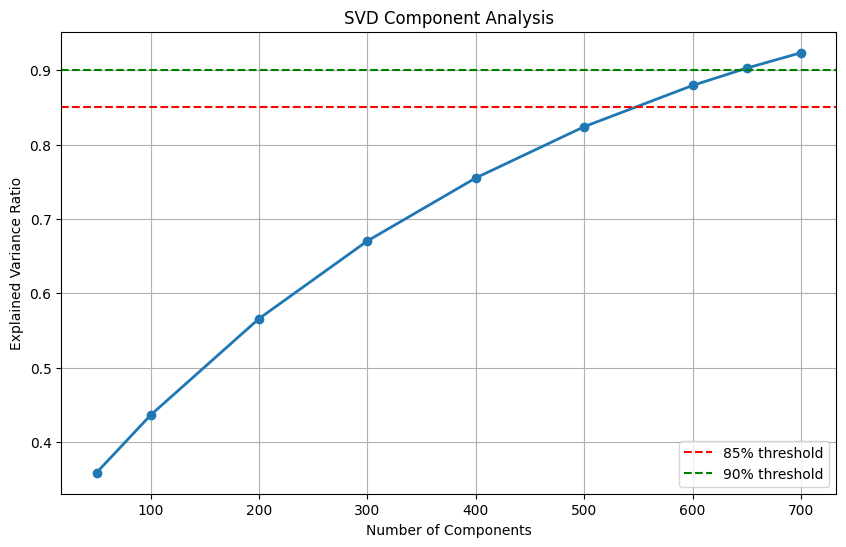

,n_components,explained_variance,cumulative_variance
0,50,0.358422,0.358422
1,100,0.436087,0.436087
2,200,0.565867,0.565867
3,300,0.670431,0.670431
4,400,0.755216,0.755216
5,500,0.824184,0.824184
6,600,0.879620,0.879620
7,650,0.902986,0.902986
8,700,0.923665,0.923665



Recommended number of components: 600


In [8]:
# SVD Component Analysis - Find optimal number of components
def analyze_svd_components(df_ratings, max_components=700):
    """
    Analyze SVD components to find optimal dimensionality
    Returns explained variance ratios for different component counts
    """
    results = []
    component_range = [50, 100, 200, 300, 400, 500, 600, 650, 700]
    
    for n_comp in component_range:
        if n_comp > min(df_ratings.shape):
            continue
            
        svd = TruncatedSVD(n_components=n_comp, random_state=67)
        svd.fit(df_ratings.values)
        
        explained_var = svd.explained_variance_ratio_.sum()
        results.append({
            'n_components': n_comp,
            'explained_variance': explained_var,
            'cumulative_variance': explained_var
        })
    
    results_df = pd.DataFrame(results)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['n_components'], results_df['explained_variance'], 'o-', linewidth=2)
    plt.axhline(y=0.85, color='r', linestyle='--', label='85% threshold')
    plt.axhline(y=0.90, color='g', linestyle='--', label='90% threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('SVD Component Analysis')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return results_df

# Test SVD optimization
df_X_no_dupes = X.drop_duplicates(subset=["user", "item"], keep="last")
df_ratings_test = df_X_no_dupes.pivot(index='user', columns='item', values='rating').fillna(-1)
all_items = range(0, 1000)
df_ratings_test = df_ratings_test.reindex(columns=all_items, fill_value=-1)

svd_results = analyze_svd_components(df_ratings_test)
display(svd_results)

# Find optimal components (targeting ~85-90% variance explained)
optimal_components = svd_results[svd_results['explained_variance'] >= 0.85]['n_components'].min()
print(f"\nRecommended number of components: {optimal_components}")

In [9]:
def engineer_features(df_X, df_y=None, n_svd_components=300):
    """
    Optimized feature engineering with configurable SVD components
    Default reduced from 650 to 300 based on variance analysis
    """
    df_X_no_dupes = df_X.drop_duplicates(subset=["user", "item"], keep="last")
    df_ratings = df_X_no_dupes.pivot(index='user', columns='item', values='rating').fillna(-1)
    all_items = range(0, 1000)
    df_ratings = df_ratings.reindex(columns=all_items, fill_value=-1)

    # Optimized SVD with fewer components
    svd = TruncatedSVD(n_components=n_svd_components, random_state=67)
    X_svd = svd.fit_transform(df_ratings.values)
    svd_cols = [f"svd_{i+1}" for i in range(X_svd.shape[1])]
    df_svd = pd.DataFrame(X_svd, columns=svd_cols, index=df_ratings.index)

    # Basic user features
    df_user_features = df_X.groupby("user").agg(
        mean_rating=("rating", "mean"),
        median_rating=("rating", "median"),
        std_rating=("rating", "std"),
        min_rating=("rating", "min"),
        max_rating=("rating", "max"),
        count_dislike=("rating", lambda x: ((x == 0) | (x == 1) | (x == 2)).sum()),
        count_neutral=("rating", lambda x: (x == 3).sum()),
        count_like=("rating", lambda x: ((x == 4) | (x == 5)).sum()),
        total_interactions=("rating", "count"),
    )

    # Remove redundant rating_var (same as std_rating^2)
    df_user_features["normalized_std"] = (
        df_user_features["std_rating"] / (df_user_features["mean_rating"] + 1e-5)
    )

    # Ratio features
    df_user_features["like_ratio"] = (
        df_user_features["count_like"] / df_user_features["total_interactions"]
    )
    df_user_features["dislike_ratio"] = (
        df_user_features["count_dislike"] / df_user_features["total_interactions"]
    )
    df_user_features["neutral_ratio"] = (
        df_user_features["count_neutral"] / df_user_features["total_interactions"]
    )

    # num_items = df_X["item"].nunique()
    # df_user_features["interaction_ratio"] = df_user_features["total_interactions"] / num_items

    # Weighted scores
    df_user_features["weighted_score"] = (
        df_user_features["count_like"] * 1.5 - df_user_features["count_dislike"] * 1.5
    )

    # Distribution features
    df_user_features["rating_kurtosis"] = df_X.groupby("user")["rating"].apply(kurtosis)
    df_user_features["rating_skewness"] = df_X.groupby("user")["rating"].apply(skew)

    # User bias (relative to item mean)
    item_means = df_X.groupby("item")["rating"].mean().rename("item_mean")
    df_tmp = df_X.merge(item_means, on="item", how="left")
    user_bias = df_tmp.groupby("user").apply(
        lambda df: (df["rating"] - df["item_mean"]).mean()
    ).rename("user_bias")
    df_user_features = df_user_features.merge(user_bias, on="user", how="left")

    # Outliers
    item_stats = df_X.groupby("item")["rating"].agg(["mean", "std"]).rename(
        columns={"mean": "item_mean", "std": "item_std"}
    )
    df_tmp = df_X.merge(item_stats, on="item", how="left")
    df_tmp["abs_dev"] = abs(df_tmp["rating"] - df_tmp["item_mean"])
    outlier_frac = (df_tmp["abs_dev"] > 1.5 * df_tmp["item_std"]).groupby(
        df_tmp["user"]
    ).mean().rename("outlier_frac")
    df_user_features = df_user_features.merge(outlier_frac, on="user", how="left")

    # Mean item alignment
    df_tmp["z_score_item"] = (df_tmp["rating"] - df_tmp["item_mean"]) / (
        df_tmp["item_std"] + 1e-6
    )
    mean_item_alignment = df_tmp.groupby("user")["z_score_item"].mean().rename(
        "mean_item_alignment"
    )
    df_user_features = df_user_features.merge(mean_item_alignment, on="user", how="left")

    # Entropy and extreme behaviour
    user_entropy = df_X.groupby("user")["rating"].apply(
        lambda x: entropy(x.value_counts(normalize=True))
    ).rename("rating_entropy")
    extreme_ratio = df_X.groupby("user").apply(
        lambda df: ((df["rating"] == 1) | (df["rating"] == 5)).mean()
    ).rename("extreme_ratio")
    df_user_features = df_user_features.merge(user_entropy, on="user", how="left")
    df_user_features = df_user_features.merge(extreme_ratio, on="user", how="left")

    # User mean rank
    df_user_features["user_mean_rank"] = df_user_features["mean_rating"].rank(pct=True)

    # Item popularity features
    item_popularity = df_X.groupby("item")["user"].nunique().rename("item_popularity")
    item_rating_count = df_X.groupby("item").size().rename("item_rating_count")
    df_tmp = df_X.merge(item_popularity, on="item", how="left")
    df_tmp = df_tmp.merge(item_rating_count, on="item", how="left")
    
    user_avg_item_popularity = df_tmp.groupby("user")["item_popularity"].mean().rename(
        "avg_item_popularity"
    )
    user_rare_item_ratio = df_tmp.groupby("user").apply(
        lambda x: (x["item_popularity"] < x["item_popularity"].quantile(0.25)).mean()
    ).rename("rare_item_ratio")
    
    df_user_features = df_user_features.merge(user_avg_item_popularity, on="user", how="left")
    df_user_features = df_user_features.merge(user_rare_item_ratio, on="user", how="left")
    
    # Rating consistency features
    user_rating_changes = df_X.sort_values(["user", "item"]).groupby("user")["rating"].apply(
        lambda x: (x.diff().abs().mean()) if len(x) > 1 else 0
    ).rename("rating_volatility")
    
    df_user_features = df_user_features.merge(user_rating_changes, on="user", how="left")
    
    # Concentration features (Herfindahl index)
    rating_concentration = df_X.groupby("user")["rating"].apply(
        lambda x: (x.value_counts(normalize=True) ** 2).sum()
    ).rename("rating_concentration")
    
    df_user_features = df_user_features.merge(rating_concentration, on="user", how="left")

    # Fill NaN values
    df_user_features = df_user_features.fillna(0)

    final_df = pd.merge(df_svd.reset_index(), df_user_features, on='user')
    
    if df_y is not None:
        df_merged = pd.merge(final_df.reset_index(), df_y, on="user", how="inner")
        return df_merged.drop(columns=["index"]).set_index("user")
    else:
        return final_df.set_index("user")

## Evaluation Functions

In [10]:
# To print MAE for regression task
def evaluate_linear_predictions(y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE: {mae:.4f}")

# To print accuracy for classification task
def evaluate_classification_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

## Regression Task

### Feature Engineering

In [11]:
# Create the initial dataframe for linear regression, using X and y
df_reg = engineer_features(X, y)
df_reg.columns = df_reg.columns.astype(str)

display(df_reg.head())

/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_bias = df_tmp.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:90: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  extreme_ratio = df_X.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:

,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,...,outlier_frac,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,avg_item_popularity,rare_item_ratio,rating_volatility,rating_concentration,label
user,,,,,,,,,,,,,,,,,,,,,
0,14.860749,-6.068257,-9.349063,-11.332684,3.569385,18.300837,1.165931,4.843467,5.262733,-3.331607,...,0.272277,-0.676871,1.407269,0.282178,0.023889,1372.925743,0.252475,1.273632,0.249240,0.962817
1,33.009061,4.579251,4.523304,-10.496718,-10.419450,-9.257935,1.974163,-2.492988,-0.088541,1.393418,...,0.038806,-0.400218,1.212858,0.083582,0.132500,1358.641791,0.250746,0.880240,0.354564,0.031248
2,36.236045,3.335757,19.619654,-9.828392,11.517358,-6.641359,-2.178109,2.165167,-1.300472,6.411729,...,0.041985,0.606235,0.866574,0.118321,0.777639,1373.125954,0.251908,0.536398,0.507750,0.068668
3,23.282289,7.201780,-3.125457,2.699728,-8.397937,7.214575,11.027766,-7.014426,-0.113976,-1.846197,...,0.211921,0.511695,1.374852,0.301325,0.732639,1223.599338,0.251656,1.016611,0.300776,0.349012
4,-35.818199,37.524453,0.308825,-7.912539,-0.218294,-0.704625,-0.070853,-0.875664,-0.148923,0.212953,...,0.000000,0.437630,0.854248,0.467836,0.970278,867.903509,0.251462,0.671554,0.463784,0.917704


In [12]:
# Prepare and split dataset into train and validation set

# Step 1: Extract features and labels
X_lr = df_reg.drop(columns=["label"]).values # Features
y_lr = df_reg["label"].values # Labels

# Step 2: Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_lr, y_lr, test_size = 0.2, random_state=67
)

print("Shapes (regression):")
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Shapes (regression):
(2880, 326) (2880,) (720, 326) (720,)


In [13]:
# Standardise features (for regression)

scaler_reg = StandardScaler().fit(X_train)
X_train_std = scaler_reg.transform(X_train)
X_val_std = scaler_reg.transform(X_val)

### Feature Selection

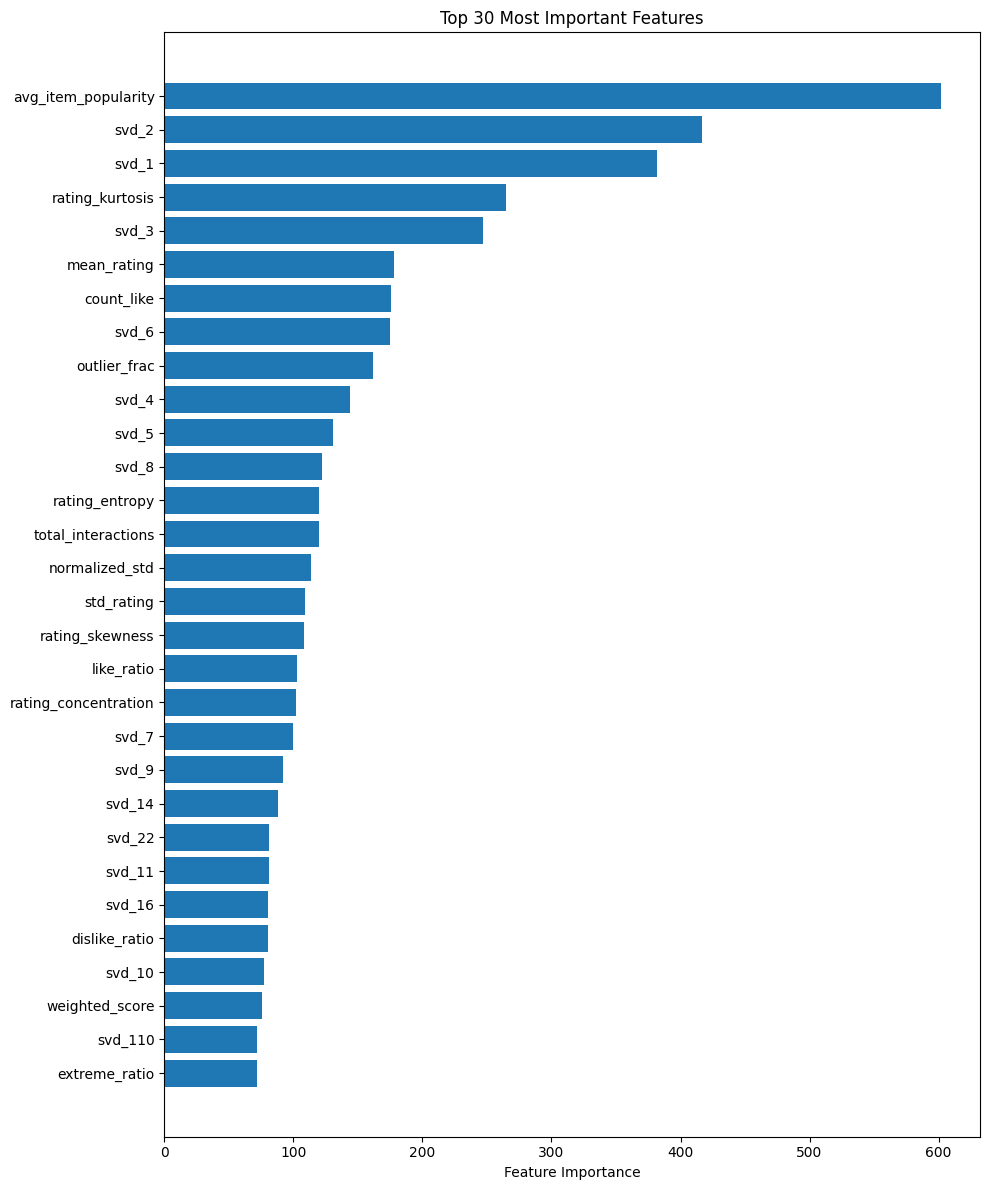

/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Threshold: mean
Features selected: 86 / 326
Validation MAE: 0.0607
Training MAE: 0.0224


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Threshold: median
Features selected: 163 / 326
Validation MAE: 0.0631
Training MAE: 0.0217


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Threshold: 0.75*mean
Features selected: 174 / 326
Validation MAE: 0.0619
Training MAE: 0.0212


,threshold,n_features,val_mae,train_mae,overfitting
0,mean,86,0.060657,0.022397,0.038260
1,median,163,0.063082,0.021701,0.041381
2,0.75*mean,174,0.061883,0.021242,0.040641



Best threshold: mean

Selected 86 features:
['svd_1', 'svd_2', 'svd_3', 'svd_4', 'svd_5', 'svd_6', 'svd_7', 'svd_8', 'svd_9', 'svd_10', 'svd_11', 'svd_12', 'svd_13', 'svd_14', 'svd_15', 'svd_16', 'svd_17', 'svd_18', 'svd_19', 'svd_20'] ...


In [14]:
### Feature Selection using LGBM Importance

from sklearn.feature_selection import SelectFromModel

# Train LGBM to get feature importances
lgbm_selector = LGBMRegressor(
    random_state=67,
    n_estimators=500,
    max_depth=6,
    num_leaves=64,
    learning_rate=0.05,
    verbose=-1
)

lgbm_selector.fit(X_train, y_train)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': df_reg.drop(columns=["label"]).columns,
    'importance': lgbm_selector.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 30 features
plt.figure(figsize=(10, 12))
top_features = feature_importance.head(30)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 30 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Select features using different thresholds
thresholds = ['mean', 'median', '0.75*mean']
results_comparison = []

for threshold in thresholds:
    selector = SelectFromModel(lgbm_selector, threshold=threshold, prefit=True)
    X_train_selected = selector.transform(X_train)
    X_val_selected = selector.transform(X_val)
    
    # Train model on selected features
    lgbm_test = LGBMRegressor(
        random_state=67,
        max_depth=6,
        num_leaves=64,
        n_estimators=5000,
        learning_rate=0.01,
        reg_lambda=0.1,
        reg_alpha=1.0,
        subsample=0.8,
        colsample_bytree=0.8,
        verbose=-1,
        objective='mae',
        metric='mae',
        min_child_samples=20,
        min_child_weight=0.001
    )
    
    lgbm_test.fit(X_train_selected, y_train)
    y_pred_val = lgbm_test.predict(X_val_selected)
    y_pred_train = lgbm_test.predict(X_train_selected)
    
    mae_val = mean_absolute_error(y_val, y_pred_val)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    
    results_comparison.append({
        'threshold': threshold,
        'n_features': X_train_selected.shape[1],
        'val_mae': mae_val,
        'train_mae': mae_train,
        'overfitting': mae_val - mae_train
    })
    
    print(f"\nThreshold: {threshold}")
    print(f"Features selected: {X_train_selected.shape[1]} / {X_train.shape[1]}")
    print(f"Validation MAE: {mae_val:.4f}")
    print(f"Training MAE: {mae_train:.4f}")

comparison_df = pd.DataFrame(results_comparison)
display(comparison_df)

# Choose best threshold
best_threshold = comparison_df.loc[comparison_df['val_mae'].idxmin(), 'threshold']
print(f"\nBest threshold: {best_threshold}")

# Create final selector
selector_final = SelectFromModel(lgbm_selector, threshold=best_threshold, prefit=True)
selected_features_mask = selector_final.get_support()
selected_feature_names = df_reg.drop(columns=["label"]).columns[selected_features_mask].tolist()

print(f"\nSelected {len(selected_feature_names)} features:")
print(selected_feature_names[:20], "...")  # Show first 20

### Linear-based models (Linear Regression, Ridge, Lasso)

In [15]:
# Linear Regression

lr = LinearRegression()
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_val_std)
y_test = lr.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.1072
Result on training set (test for overfitting):
MAE: 0.0910


In [16]:
# Ridge Regression

ridge = Ridge(alpha=0.1)
ridge.fit(X_train_std, y_train)
y_pred = ridge.predict(X_val_std)
y_test = ridge.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.1071
Result on training set (test for overfitting):
MAE: 0.0911


In [17]:
# Lasso Regression

lasso = Lasso(alpha=0.1)
lasso.fit(X_train_std, y_train)
y_pred = lasso.predict(X_val_std)
y_test = lasso.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.2079
Result on training set (test for overfitting):
MAE: 0.2194


In [18]:
# Stochastic Gradient Descent (SGD) Regression

sgd = SGDRegressor(random_state=67)
sgd.fit(X_train_std, y_train)
y_pred = sgd.predict(X_val_std)
y_test = sgd.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.1182
Result on training set (test for overfitting):
MAE: 0.1059


It appears that all linear-based models do not perform very well, which is expected as the data is not likely to follow a linear distribution.  
We thus attempt using other models.

### Tree-based models (DecisionTree, XGBRegressor, LGBMRegressor, CatBoostRegressor)

In [19]:
# Decision Tree Regressor

dtr = DecisionTreeRegressor(random_state=67)
dtr.fit(X_train, y_train)
y_pred = dtr.predict(X_val)
y_test = dtr.predict(X_train)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.0935
Result on training set (test for overfitting):
MAE: 0.0000


In [20]:
# XGB Regressor 
# XGB is an optimised software library that uses gradient boosted decision trees
# We first try it without tweaking parameters

xgbr = XGBRegressor(random_state=67)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_val)
y_test = xgbr.predict(X_train)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.0665
Result on training set (test for overfitting):
MAE: 0.0013


In [21]:
# LightGBM Regressor
# LightGBM is another well-known gradient boosting framework for efficient regression
# We first try it without tweaking parameters

lgbm = LGBMRegressor(random_state=67)

lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_val)
y_test = lgbm.predict(X_train)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.0619
Result on training set (test for overfitting):
MAE: 0.0187


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [22]:
# CatBoostRegressor
# CatBoost is the last of the well-known gradient boosting frameworks, known for its 
# high accuracy and ability to handle categorical features directly
# We first try it without tweaking parameters

cbr = CatBoostRegressor(random_state=67, verbose=0)

cbr.fit(X_train_std, y_train)
y_pred = cbr.predict(X_val_std)
y_test = cbr.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.0664
Result on training set (test for overfitting):
MAE: 0.0150


In [23]:
# LGBMRegressor appears to have the best performance without overfitting that much
# We try to tune LGBMRegressor even more to deliver the best performance

lgbm = LGBMRegressor(
    random_state=67,
    max_depth=6,
    num_leaves=64,
    n_estimators=5000,
    learning_rate=0.01,
    reg_lambda=0.1,
    reg_alpha=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    verbose=-1,
    objective='mae',
    metric='mae',
    min_child_samples=20,
    min_child_weight=0.001
)

from sklearn.preprocessing import QuantileTransformer

target_transformer = QuantileTransformer(output_distribution='normal', random_state=67)
y_train_transformed = target_transformer.fit_transform(y_train.reshape(-1, 1)).ravel()

lgbm.fit(X_train, y_train_transformed)
y_pred_transformed = lgbm.predict(X_val)
y_pred = target_transformer.inverse_transform(y_pred_transformed.reshape(-1, 1)).ravel()
y_test = lgbm.predict(X_train)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Validation result:
MAE: 0.0623
Result on training set (test for overfitting):
MAE: 0.6460


In [24]:
# Additional code used to find LGBMRegressor parameters

# Define ranges to sweep
# depths = [3, 4, 5, 6, 7, 8]
# lambdas = [0.0, 0.1, 0.5, 1.0]
# learning_rates = [0.005, 0.008, 0.01]

# results = []

# # Sweep over hyperparameters
# for depth in depths:
#     for lam in lambdas:
#         for lr in learning_rates:
#             model = LGBMRegressor(
#                 random_state=67,
#                 max_depth=depth,
#                 num_leaves=2**depth,       # roughly matched to depth
#                 n_estimators=3500,
#                 learning_rate=lr,
#                 reg_lambda=lam,
#                 reg_alpha=0.1,
#                 subsample=0.9,
#                 colsample_bytree=0.9,
#                 verbose=-1,
#             )

#             model.fit(X_train_std, y_train)
#             y_train_pred = model.predict(X_train_std)
#             y_val_pred = model.predict(X_val_std)

#             train_mae = mean_absolute_error(y_train, y_train_pred)
#             val_mae = mean_absolute_error(y_val, y_val_pred)
#             results.append((depth, lam, lr, train_mae, val_mae))

# # Convert to numpy for easy slicing
# results = np.array(results, dtype=object)

# # Pick the lowest validation MAE combo
# best_idx = np.argmin(results[:, 4].astype(float))
# best = results[best_idx]
# print(f"\nBest config: depth={best[0]}, lambda={best[1]}, lr={best[2]} "
#       f"→ train MAE={best[3]:.5f}, val MAE={best[4]:.5f}")

# # Plot curves by depth for the best lambda/lr combination
# plt.figure(figsize=(8, 5))
# for lam in lambdas:
#     subset = results[results[:, 1] == lam]
#     plt.plot(subset[:, 0], subset[:, 3].astype(float), 'o--', label=f"Train λ={lam}")
#     plt.plot(subset[:, 0], subset[:, 4].astype(float), 'o-', label=f"Val λ={lam}")

# plt.xlabel("max_depth")
# plt.ylabel("MAE")
# plt.title("Train vs Validation MAE across model complexity")
# plt.legend()
# plt.grid(True)
# plt.show()

We find that Tree-based models perform much better than Linear-based models, which is understandable as the data likely does not follow a linear distribution.  
In particular, the LGBM Regressor gave an exceptionally good performance out of the 3 most well-known gradient boosting frameworks.  
This is likely because LGBM grows leaf-wise: it chooses the single leaf with the highest loss reduction to split next. Since our engineered features capture strong but localised signals, LightGBM's leaf-wise search can find them efficiently.  
Based off this, we further fine-tuned LGBMRegressor to deliver the best performance we could.  

### Ensemble-based models (RandomForest, BaggingRegressor)

In [25]:
# Random Forest Regressor
rfr = RandomForestRegressor(random_state=67)
rfr.fit(X_train_std, y_train)
y_pred = rfr.predict(X_val_std)
y_test = rfr.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.0672
Result on training set (test for overfitting):
MAE: 0.0267


In [26]:
# Since Random Forest Regressor delivered great performance, we tried tuning it further
# The performance did not increase much despite our best efforts

rfr2 = RandomForestRegressor(
    random_state=67,
    n_estimators=1200,
    n_jobs=-1,
    max_depth=17,
    min_samples_leaf=3,
    min_samples_split=10,
    max_features=0.7,
    )

rfr2.fit(X_train_std, y_train)
y_pred = rfr2.predict(X_val_std)
y_test = rfr2.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.0654
Result on training set (test for overfitting):
MAE: 0.0320


In [27]:
# Bagging Regressor

br = BaggingRegressor(random_state=67)
br.fit(X_train_std, y_train)
y_pred = br.predict(X_val_std)
y_test = br.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.0710
Result on training set (test for overfitting):
MAE: 0.0306


Ensemble-based methods also provide good performance out-of-the-box, but we find that Tree-based regressors provide the best performance out of all the supervised learning methods.

### Neural Network models

In [28]:
# Multi-layer perceptron (MLP) Regressor with 4 layers

mlp = MLPRegressor(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.1,
    learning_rate_init=0.003,
    max_iter=5000,
    random_state=67,
    batch_size=128
)

mlp.fit(X_train_std, y_train)
y_pred = mlp.predict(X_val_std)
y_test = mlp.predict(X_train_std)

print("Validation result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

Validation result:
MAE: 0.0850
Result on training set (test for overfitting):
MAE: 0.0425


After some fine tuning, the MLP Regressor is able to get decent performance on the validation dataset, but still not as good as the other types of models.

### Unsupervised models

In [29]:
# Trying out PCA + LGBMRegressor

pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_std)
X_val_pca = pca.transform(X_val_std)

lgbm2 = LGBMRegressor(
    random_state=67,
    max_depth=6,
    num_leaves=64,
    n_estimators=5000,
    learning_rate=0.01,
    reg_lambda=0.1,
    reg_alpha=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    verbose=-1,
    objective='mae',
    metric='mae'
)

lgbm2.fit(X_train_pca, y_train)
y_pred = lgbm2.predict(X_val_pca)
y_test = lgbm2.predict(X_train_pca)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Actual result:
MAE: 0.1426
Result on training set (test for overfitting):
MAE: 0.0489


Reducing the dimensionality of the data does not seem to work very well overall, even when we vary the number of components.

### Stacking uncorrelated models

In [30]:
# We check the correlations between the predictions of the best models
# If the models are too closely related, there is no point in stacking them

pred_xgb = xgbr.predict(X_val_std)
pred_lgbm = lgbm.predict(X_val_std)
pred_cbr = cbr.predict(X_val_std)
pred_rfr = rfr2.predict(X_val_std)
pred_mlp = mlp.predict(X_val_std)

corr_matrix = np.corrcoef([pred_xgb, pred_lgbm, pred_cbr, pred_rfr, pred_mlp])
print(corr_matrix)

/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[[1.         0.60365792 0.31032818 0.29620446 0.28511552]
 [0.60365792 1.         0.46708105 0.44877844 0.45135834]
 [0.31032818 0.46708105 1.         0.98698914 0.93715822]
 [0.29620446 0.44877844 0.98698914 1.         0.93479879]
 [0.28511552 0.45135834 0.93715822 0.93479879 1.        ]]


In [31]:
# We try stacking models that are not strongly correlated (corr < 0.95)
# This can potentially improve our performance, as the MLP can capture smooth nonlinear patterns missed by tree models
# The stacking regressor can combine these predictions to reduce both bias and variance, improving overall MAE

stack = StackingRegressor(
    estimators=[
        ("lgbm", LGBMRegressor(
            random_state=67,
            max_depth=6,
            num_leaves=64,
            n_estimators=5000,
            learning_rate=0.01,
            reg_lambda=0.1,
            reg_alpha=1.0,
            subsample=0.8,
            colsample_bytree=0.8,
            verbose=-1,
            objective='mae',
            metric='mae'
        )),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=(128, 64),
            activation='relu',
            solver='adam',
            alpha=0.1,
            learning_rate_init=0.003,
            max_iter=5000,
            random_state=67,
            batch_size=128
        ))
    ],
    final_estimator=Ridge(alpha=0.1)
)

stack.fit(X_train_std, y_train)
y_pred = stack.predict(X_val_std)
y_test = stack.predict(X_train_std)

print("Actual result:")
evaluate_linear_predictions(y_val, y_pred)
print("Result on training set (test for overfitting):")
evaluate_linear_predictions(y_train, y_test)

/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does 

Actual result:
MAE: 0.0624
Result on training set (test for overfitting):
MAE: 0.0264


Our hypothesis that stacking the two regressors increases performance does not prove true; the tuned LGBMRegressor still leads to roughly equivalent performance, and the slight improvement observed might just be due to noise.  
We thus then retrain the single LGBMRegressor model with tuned parameters on the full dataset, to prepare it to predict on the final batch of data.

### Preparing final regression model

In [32]:
# # Training final model on full dataset

# scaler_full = StandardScaler()
# X_all_std = scaler_full.fit_transform(X_lr)

# lgbm_final = LGBMRegressor(
#     random_state=67,
#     max_depth=6,
#     num_leaves=64,
#     n_estimators=5000,
#     learning_rate=0.01,
#     reg_lambda=0.1,
#     reg_alpha=1.0,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     verbose=-1,
#     objective='mae',
#     metric='mae'
# )

# lgbm_final.fit(X_all_std, y_lr)

In [33]:
### Training Final Model with Optimized Features

# Regenerate features with optimal SVD components
print("Regenerating features with optimized parameters...")
df_reg_optimized = engineer_features(X, y, n_svd_components=300)
df_reg_optimized.columns = df_reg_optimized.columns.astype(str)

# Extract features and labels
X_lr_optimized = df_reg_optimized.drop(columns=["label"]).values
y_lr_optimized = df_reg_optimized["label"].values

# Split for validation
X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(
    X_lr_optimized, y_lr_optimized, test_size=0.2, random_state=67
)

print(f"Original features: {X_train_opt.shape[1]}")

# ==========================================
# RETRAIN FEATURE SELECTOR ON NEW FEATURES
# ==========================================
print("\n=== Retraining Feature Selector on Optimized Features ===")

# Train new LGBM for feature importance
lgbm_selector_optimized = LGBMRegressor(
    random_state=67,
    n_estimators=500,
    max_depth=6,
    num_leaves=64,
    learning_rate=0.05,
    verbose=-1
)

lgbm_selector_optimized.fit(X_train_opt, y_train_opt)

# Get feature importances for optimized features
feature_importance_opt = pd.DataFrame({
    'feature': df_reg_optimized.drop(columns=["label"]).columns,
    'importance': lgbm_selector_optimized.feature_importances_
}).sort_values('importance', ascending=False)

# Display top features
print("\nTop 20 most important features:")
print(feature_importance_opt.head(20))

# Try different thresholds to find best one
thresholds = ['mean', 'median', '0.75*mean']
results_comparison_opt = []

for threshold in thresholds:
    from sklearn.feature_selection import SelectFromModel
    
    selector_temp = SelectFromModel(lgbm_selector_optimized, threshold=threshold, prefit=True)
    X_train_selected_temp = selector_temp.transform(X_train_opt)
    X_val_selected_temp = selector_temp.transform(X_val_opt)
    
    # Train model on selected features
    lgbm_test = LGBMRegressor(
        random_state=67,
        max_depth=6,
        num_leaves=64,
        n_estimators=5000,
        learning_rate=0.01,
        reg_lambda=0.1,
        reg_alpha=1.0,
        subsample=0.8,
        colsample_bytree=0.8,
        verbose=-1,
        objective='mae',
        metric='mae',
        min_child_samples=20,
        min_child_weight=0.001
    )
    
    lgbm_test.fit(X_train_selected_temp, y_train_opt)
    y_pred_val_temp = lgbm_test.predict(X_val_selected_temp)
    y_pred_train_temp = lgbm_test.predict(X_train_selected_temp)
    
    mae_val_temp = mean_absolute_error(y_val_opt, y_pred_val_temp)
    mae_train_temp = mean_absolute_error(y_train_opt, y_pred_train_temp)
    
    results_comparison_opt.append({
        'threshold': threshold,
        'n_features': X_train_selected_temp.shape[1],
        'val_mae': mae_val_temp,
        'train_mae': mae_train_temp,
        'overfitting': mae_val_temp - mae_train_temp
    })
    
    print(f"\nThreshold: {threshold}")
    print(f"Features selected: {X_train_selected_temp.shape[1]} / {X_train_opt.shape[1]}")
    print(f"Validation MAE: {mae_val_temp:.4f}")
    print(f"Training MAE: {mae_train_temp:.4f}")

comparison_df_opt = pd.DataFrame(results_comparison_opt)
display(comparison_df_opt)

# Choose best threshold
best_threshold_opt = comparison_df_opt.loc[comparison_df_opt['val_mae'].idxmin(), 'threshold']
print(f"\nBest threshold: {best_threshold_opt}")

# Create FINAL selector for optimized features
selector_final_optimized = SelectFromModel(
    lgbm_selector_optimized, 
    threshold=best_threshold_opt, 
    prefit=True
)

# Apply feature selection
X_train_opt_selected = selector_final_optimized.transform(X_train_opt)
X_val_opt_selected = selector_final_optimized.transform(X_val_opt)

print(f"\nSelected features: {X_train_opt_selected.shape[1]} / {X_train_opt.shape[1]}")

# ==========================================
# TRAIN FINAL MODEL
# ==========================================
print("\n=== Training Final Model ===")

lgbm_final = LGBMRegressor(
    random_state=67,
    max_depth=6,
    num_leaves=64,
    n_estimators=5000,
    learning_rate=0.01,
    reg_lambda=0.1,
    reg_alpha=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    verbose=-1,
    objective='mae',
    metric='mae',
    min_child_samples=20,
    min_child_weight=0.001
)

lgbm_final.fit(X_train_opt_selected, y_train_opt)
y_pred_final = lgbm_final.predict(X_val_opt_selected)

print("\nOptimized Model Performance:")
print(f"Validation MAE: {mean_absolute_error(y_val_opt, y_pred_final):.4f}")

# Train on full dataset
X_all_opt_selected = selector_final_optimized.transform(X_lr_optimized)
lgbm_final.fit(X_all_opt_selected, y_lr_optimized)

print("\nFinal model trained on full dataset with optimized features!")

Regenerating features with optimized parameters...


/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_bias = df_tmp.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:90: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  extreme_ratio = df_X.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:

Original features: 326

=== Retraining Feature Selector on Optimized Features ===

Top 20 most important features:
                  feature  importance
322   avg_item_popularity         602
1                   svd_2         417
0                   svd_1         382
314       rating_kurtosis         265
2                   svd_3         247
300           mean_rating         178
307            count_like         176
5                   svd_6         175
317          outlier_frac         162
3                   svd_4         144
4                   svd_5         131
7                   svd_8         122
319        rating_entropy         120
308    total_interactions         120
309        normalized_std         114
302            std_rating         109
315       rating_skewness         108
310            like_ratio         103
325  rating_concentration         102
6                   svd_7         100


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Threshold: mean
Features selected: 86 / 326
Validation MAE: 0.0607
Training MAE: 0.0224


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Threshold: median
Features selected: 163 / 326
Validation MAE: 0.0631
Training MAE: 0.0217


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Threshold: 0.75*mean
Features selected: 174 / 326
Validation MAE: 0.0619
Training MAE: 0.0212


,threshold,n_features,val_mae,train_mae,overfitting
0,mean,86,0.060657,0.022397,0.038260
1,median,163,0.063082,0.021701,0.041381
2,0.75*mean,174,0.061883,0.021242,0.040641



Best threshold: mean

Selected features: 86 / 326

=== Training Final Model ===


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(



Optimized Model Performance:
Validation MAE: 0.0607

Final model trained on full dataset with optimized features!


## Classification Task

### Feature Engineering

In [34]:
# Combine dataframe with anomtype: use y_cat instead of y

df_cla = engineer_features(X, y_cat)

# We convert all column names to strings so it does not throw an error later
df_cla.columns = df_cla.columns.astype(str)
display(df_cla)
df_cla["anomtype"].value_counts()

/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_bias = df_tmp.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:90: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  extreme_ratio = df_X.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:

,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,...,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,avg_item_popularity,rare_item_ratio,rating_volatility,rating_concentration,label,anomtype
user,,,,,,,,,,,,,,,,,,,,,
26,19.405226,1.056769,-21.038527,1.067305,26.873600,3.613976,-2.008504,-1.611251,4.041583,-4.170670,...,-0.399362,1.503556,0.151639,0.248333,1296.213115,0.250000,1.395062,0.254065,0.558222,0
199,24.701986,4.278532,-6.918118,-14.194389,4.933048,8.060955,6.287393,4.449363,-1.056309,-0.967260,...,0.100368,1.441563,0.189573,0.515833,1429.568720,0.251185,1.219048,0.276117,0.165112,1
202,-30.651479,27.972663,-1.808480,-11.094628,0.104153,0.539192,-0.447467,-1.427426,-0.590070,0.858616,...,0.477618,0.745018,0.471963,0.987222,873.476636,0.252336,0.516432,0.491833,0.925028,2
205,4.077090,27.859159,17.445291,-5.786915,-12.944545,-2.128206,-3.253641,-6.447440,2.451911,-3.451880,...,0.170565,1.399122,0.234332,0.651111,1128.376022,0.250681,1.019126,0.279347,0.380860,2
231,34.053427,3.629981,-14.458684,-5.522036,-10.271650,-4.786838,2.645228,9.534818,-3.295730,0.831030,...,-0.633656,1.384519,0.265363,0.028056,1383.776536,0.251397,1.263305,0.250882,0.951103,0
284,19.995440,-3.963606,36.543998,-12.160488,-0.507532,10.580456,-0.204711,1.751987,4.764085,-3.733991,...,0.846178,0.858244,0.219731,0.859167,1249.322870,0.251121,0.540541,0.511392,0.055162,2
424,19.515725,1.946307,-11.297455,-12.750778,-1.955778,5.562889,2.733605,-0.980205,-1.747588,-3.314120,...,0.079770,1.255755,0.075000,0.479167,1388.605000,0.250000,0.864322,0.327250,0.255181,1
459,19.229018,-4.886454,20.073144,-14.276159,7.799430,1.149055,9.521034,-0.200415,-3.550065,5.731454,...,-0.395315,1.475948,0.256522,0.178333,1343.843478,0.252174,1.371179,0.242722,0.739300,0
469,15.833040,10.900338,17.698568,-12.457373,2.723195,-2.610725,8.489573,-7.575831,-0.392949,-2.492455,...,0.079066,1.315856,0.148699,0.533056,1279.308550,0.249071,0.891791,0.311618,0.233492,2


anomtype
0    20
1    20
2    20
Name: count, dtype: int64

In [35]:
# Separate the dataframes into input X and label y

X_log = df_cla.drop(columns=["label", "anomtype"])
y_log = df_cla["anomtype"]

display(X_log)
display(y_log)

,svd_1,svd_2,svd_3,svd_4,svd_5,svd_6,svd_7,svd_8,svd_9,svd_10,...,user_bias,outlier_frac,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,avg_item_popularity,rare_item_ratio,rating_volatility,rating_concentration
user,,,,,,,,,,,,,,,,,,,,,
26,19.405226,1.056769,-21.038527,1.067305,26.873600,3.613976,-2.008504,-1.611251,4.041583,-4.170670,...,-0.439797,0.143443,-0.399362,1.503556,0.151639,0.248333,1296.213115,0.250000,1.395062,0.254065
199,24.701986,4.278532,-6.918118,-14.194389,4.933048,8.060955,6.287393,4.449363,-1.056309,-0.967260,...,0.109502,0.123223,0.100368,1.441563,0.189573,0.515833,1429.568720,0.251185,1.219048,0.276117
202,-30.651479,27.972663,-1.808480,-11.094628,0.104153,0.539192,-0.447467,-1.427426,-0.590070,0.858616,...,0.500438,0.004673,0.477618,0.745018,0.471963,0.987222,873.476636,0.252336,0.516432,0.491833
205,4.077090,27.859159,17.445291,-5.786915,-12.944545,-2.128206,-3.253641,-6.447440,2.451911,-3.451880,...,0.171325,0.059946,0.170565,1.399122,0.234332,0.651111,1128.376022,0.250681,1.019126,0.279347
231,34.053427,3.629981,-14.458684,-5.522036,-10.271650,-4.786838,2.645228,9.534818,-3.295730,0.831030,...,-0.691520,0.270950,-0.633656,1.384519,0.265363,0.028056,1383.776536,0.251397,1.263305,0.250882
284,19.995440,-3.963606,36.543998,-12.160488,-0.507532,10.580456,-0.204711,1.751987,4.764085,-3.733991,...,0.915377,0.152466,0.846178,0.858244,0.219731,0.859167,1249.322870,0.251121,0.540541,0.511392
424,19.515725,1.946307,-11.297455,-12.750778,-1.955778,5.562889,2.733605,-0.980205,-1.747588,-3.314120,...,0.097125,0.060000,0.079770,1.255755,0.075000,0.479167,1388.605000,0.250000,0.864322,0.327250
459,19.229018,-4.886454,20.073144,-14.276159,7.799430,1.149055,9.521034,-0.200415,-3.550065,5.731454,...,-0.441914,0.239130,-0.395315,1.475948,0.256522,0.178333,1343.843478,0.252174,1.371179,0.242722
469,15.833040,10.900338,17.698568,-12.457373,2.723195,-2.610725,8.489573,-7.575831,-0.392949,-2.492455,...,0.082205,0.048327,0.079066,1.315856,0.148699,0.533056,1279.308550,0.249071,0.891791,0.311618


user
26      0
199     1
202     2
205     2
231     0
284     2
424     1
459     0
469     2
561     1
667     0
699     2
730     1
786     0
849     1
1045    2
1057    0
1066    2
1151    1
1279    0
1289    2
1307    1
1450    0
1455    1
1561    1
1563    2
1617    0
1640    0
1682    2
1722    1
1818    2
1822    2
1865    2
1903    1
2093    0
2120    0
2163    2
2225    1
2328    1
2390    0
2458    1
2543    0
2548    1
2595    0
2648    2
2767    1
2778    0
2782    2
2800    1
2807    0
2938    2
2980    0
3082    0
3123    1
3153    2
3292    1
3401    1
3465    2
3499    0
3576    2
Name: anomtype, dtype: int64

In [36]:
# Scale features in X

scaler_cla = StandardScaler().fit(X_log)
X_log_std = scaler_cla.transform(X_log)

### Logistic Regression

In [37]:
# Logistic Regression

log_reg = LogisticRegression(
    penalty="elasticnet",
    l1_ratio=0.5,
    C=0.01,
    solver="saga",
    max_iter=10000
)

# Wrap log_reg in OneVsRest classifier so the solver works for our multiclass classifier
log_classifier = OneVsRestClassifier(log_reg)

# Using StratifiedKFold, for n_splits=5, we train on 4 folds and validate on the remaining fold
# then compute accuracy based on that fold
cv = StratifiedKFold(n_splits=5)

# Code for GridSearchCV: to find the best value of C
param_grid = {
    'estimator__C': [0.1, 1, 10], 
    'estimator__l1_ratio': [0.25, 0.5, 0.75]}
grid = GridSearchCV(
    estimator=log_classifier,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy'
)

grid.fit(X_log_std, y_log)

print("Best C:", grid.best_params_)
print("Best CV Accuracy: %.4f" % grid.best_score_)

# Check the results of GridSearchCV on the parameters
cv_results = pd.DataFrame(grid.cv_results_)
display(cv_results[[
    'param_estimator__C', 
    'param_estimator__l1_ratio', 
    'mean_test_score', 
    'std_test_score']])

Best C: {'estimator__C': 0.1, 'estimator__l1_ratio': 0.5}
Best CV Accuracy: 0.7167


,param_estimator__C,param_estimator__l1_ratio,mean_test_score,std_test_score
0,0.1,0.25,0.700000,0.113039
1,0.1,0.50,0.716667,0.084984
2,0.1,0.75,0.683333,0.081650
3,1.0,0.25,0.700000,0.124722
4,1.0,0.50,0.716667,0.113039
5,1.0,0.75,0.666667,0.074536
6,10.0,0.25,0.716667,0.040825
7,10.0,0.50,0.716667,0.040825
8,10.0,0.75,0.716667,0.084984


In [38]:
# To get final logistic regression model, we choose the best value of C
# We don't use logistic regression as our model, so we comment this code out

# log_reg = LogisticRegression(
#     penalty="elasticnet",
#     C=grid.best_params_['estimator__C'],
#     l1_ratio=grid.best_params_['estimator__l1_ratio'],
#     solver="saga",
#     max_iter=10000
# )

# log_classifier = OneVsRestClassifier(log_reg)

# final_model = log_classifier.fit(X_log_std, y_log)
# final_model

We are able to get an overall maximum accuracy of 70% using this Logistic Regression model trained on ElasticNet.  
We move on to see if unsupervised and semi-supervised methods can help us attain a higher accuracy.

### Unsupervised methods (KMeans)

In [39]:
# We try and cluster users just based off the created features
# Create a dataframe without noise level nor anomtype

df_cla_2 = engineer_features(X)
df_cla_2 = df_cla_2.iloc[:, -23:]

# # We convert all column names to strings so it does not throw an error later
df_cla_2.columns = df_cla_2.columns.astype(str)
df_cla_2.head()

/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_bias = df_tmp.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:90: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  extreme_ratio = df_X.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:

,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,normalized_std,like_ratio,dislike_ratio,neutral_ratio,...,user_bias,outlier_frac,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,avg_item_popularity,rare_item_ratio,rating_volatility,rating_concentration
user,,,,,,,,,,,,,,,,,,,,,
0,1,5,108,45,49,202,0.470231,0.242574,0.534653,0.222772,...,-0.750701,0.272277,-0.676871,1.407269,0.282178,0.023889,1372.925743,0.252475,1.273632,0.249240
1,1,5,138,154,43,335,0.310541,0.128358,0.411940,0.459701,...,-0.434637,0.038806,-0.400218,1.212858,0.083582,0.132500,1358.641791,0.250746,0.880240,0.354564
2,2,5,1,54,207,262,0.147537,0.790076,0.003817,0.206107,...,0.665060,0.041985,0.606235,0.866574,0.118321,0.777639,1373.125954,0.251908,0.536398,0.507750
3,0,5,36,53,213,302,0.284512,0.705298,0.119205,0.175497,...,0.550003,0.211921,0.511695,1.374852,0.301325,0.732639,1223.599338,0.251656,1.016611,0.300776
4,2,5,7,6,329,342,0.143587,0.961988,0.020468,0.017544,...,0.443621,0.000000,0.437630,0.854248,0.467836,0.970278,867.903509,0.251462,0.671554,0.463784


In [40]:
# Scale the features for KMeans (separate scaler for separate dataframe)

scaler_features = StandardScaler()
df_cla_2_scaled = scaler_features.fit_transform(df_cla_2)
df_cla_2_scaled

array([[ 0.4614703 ,  0.217773  ,  0.67637463, ...,  1.07189726,
         0.97681459, -0.90660634],
       [ 0.4614703 ,  0.217773  ,  1.17403758, ...,  0.55319392,
        -0.49082773,  0.45819998],
       [ 1.95141924,  0.217773  , -1.09862321, ...,  0.90183891,
        -1.77360743,  2.44320143],
       ...,
       [-1.02847864,  0.217773  , -0.66731532, ..., -1.82728064,
         0.19511647,  0.16412522],
       [-1.02847864,  0.217773  ,  0.62660834, ...,  0.61021326,
         1.37252393, -1.55390269],
       [-1.02847864,  0.217773  , -0.73367038, ..., -0.31911795,
        -0.49689691,  0.79808305]], shape=(3600, 23))

In [41]:
# Bring the features back into a dataframe

X_kmeans = pd.DataFrame(
    df_cla_2_scaled,
    columns=df_cla_2.columns,
    index=df_cla_2.index
)
X_kmeans

,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,normalized_std,like_ratio,dislike_ratio,neutral_ratio,...,user_bias,outlier_frac,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,avg_item_popularity,rare_item_ratio,rating_volatility,rating_concentration
user,,,,,,,,,,,,,,,,,,,,,
0,0.461470,0.217773,0.676375,-0.753724,-1.307564,-1.101748,1.455813,-1.223091,2.072483,-0.360042,...,-1.729360,1.555813,-1.677011,0.549713,0.394985,-1.649779,1.003710,1.071897,0.976815,-0.906606
1,0.461470,0.217773,1.174038,1.206414,-1.375877,0.161638,0.032727,-1.721433,1.295657,1.452570,...,-1.019037,-0.879531,-1.009237,-0.370275,-1.139736,-1.273539,0.922383,0.553194,-0.490828,0.458200
2,1.951419,0.217773,-1.098623,-0.591878,0.491361,-0.531799,-1.419891,1.165742,-1.287937,-0.487540,...,1.452419,-0.846373,1.420099,-2.008956,-0.871282,0.961288,1.004850,0.901839,-1.773607,2.443201
3,-1.028479,0.217773,-0.518016,-0.609861,0.559675,-0.151833,-0.199227,0.795841,-0.557479,-0.721721,...,1.193840,0.926231,1.191901,0.396310,0.542944,0.805404,0.153503,0.826007,0.017939,-0.238795
4,1.951419,0.217773,-0.999091,-1.455058,1.880405,0.228133,-1.455088,1.915819,-1.182528,-1.930129,...,0.954757,-1.284317,1.013126,-2.067286,1.829722,1.628609,-1.871693,0.767914,-1.269377,1.873478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,-1.028479,0.217773,-0.435073,0.001559,-0.430872,-0.607792,-0.193510,-0.117082,-0.290259,0.556078,...,-0.081018,-0.339776,-0.094876,0.042066,-0.964181,-0.066876,-0.905806,0.919871,-0.117763,0.123364
3596,-1.028479,0.217773,-0.766848,-1.077417,0.855701,-0.294320,-0.451492,1.351945,-0.848897,-1.344620,...,0.674505,-0.811832,0.705402,-0.350036,1.283952,1.204257,-1.058761,0.590638,-0.239701,0.545020
3597,-1.028479,0.217773,-0.667315,-0.825656,0.924014,-0.047343,-0.227664,1.133765,-0.766024,-1.062213,...,1.187697,0.115373,1.216609,0.012196,0.954901,1.038749,0.212611,-1.827281,0.195116,0.164125


In [42]:
# Apply KMeans to sort the users into diffent clusters

kmeans = KMeans(n_clusters=3, random_state=67)
X_kmeans["cluster"] = kmeans.fit_predict(X_kmeans)
X_kmeans["cluster"]

user
0       1
1       1
2       0
3       2
4       0
       ..
3595    2
3596    0
3597    0
3598    1
3599    2
Name: cluster, Length: 3600, dtype: int32

In [43]:
# Merge with y_cat to check the difference between the predicted clusters and actual anomtype

merged_df = pd.merge(X_kmeans, y_cat, on="user", how="inner")
merged_df = merged_df[["user", "cluster", "anomtype"]]
display(merged_df)

,user,cluster,anomtype
0,26,1,0
1,199,2,1
2,202,0,2
3,205,2,2
4,231,1,0
5,284,0,2
6,424,2,1
7,459,1,0
8,469,2,2
9,561,2,1


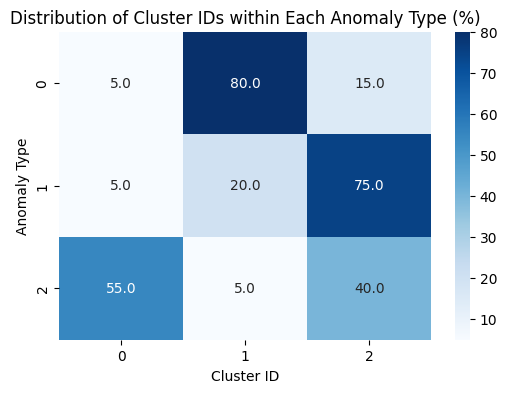

In [44]:
# Create heatmap for easy visualisation

ct = pd.crosstab(merged_df["anomtype"], merged_df["cluster"], normalize='index') * 100
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, cmap="Blues", fmt=".1f")
plt.title("Distribution of Cluster IDs within Each Anomaly Type (%)")
plt.ylabel("Anomaly Type")
plt.xlabel("Cluster ID")
plt.show()

From this heatmap, we see that the best possible accuracy we can achieve is 70%, if we do the following mapping:
- Cluster ID 0 to anomaly type 1
- Cluster ID 1 to anomaly type 0
- Cluster ID 2 to anomaly type 2.  

This is equal than the accuracy obtained from logistic regression (70%).

Lastly, we try using PCA in addition to KMeans to see if it improves our performance.  

### Unsupervised methods (PCA + KMeans)

In [45]:
# Apply PCA to reduce features to 3 dimensions
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_cla_2_scaled)

# Train KMeans on PCA-transformed features
pca_kmeans = KMeans(n_clusters=3, random_state=67)
pca_clusters = pca_kmeans.fit_predict(X_pca)

# Save clusters from numpy array into a dataframe
df_pca_kmeans = pd.DataFrame(X_pca, index=df_cla_2.index, columns=[
    "PC1", "PC2", "PC3"
    ])
df_pca_kmeans["cluster"] = pca_clusters

df_pca_kmeans

,PC1,PC2,PC3,cluster
user,,,,
0,-4.749493,-1.280293,-1.857948,1
1,-3.302685,3.140477,-0.289164,0
2,4.136726,2.363126,-2.004187,2
3,1.800030,-1.726738,-0.143201,2
4,6.464794,-0.801436,0.172996,2
...,...,...,...,...
3595,0.057448,0.765472,-0.206694,0
3596,4.024893,-1.992253,0.440857,2
3597,3.395013,-2.337388,0.636940,2


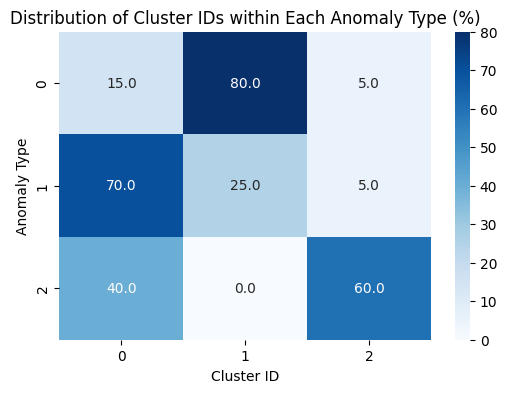

In [46]:
# Check how clusters align with true anomaly types
pca_merged = pd.merge(df_pca_kmeans, y_cat, on="user", how="inner")

# View alignment
ct = pd.crosstab(pca_merged["anomtype"], pca_merged["cluster"], normalize="index") * 100
plt.figure(figsize=(6,4))
sns.heatmap(ct, annot=True, cmap="Blues", fmt=".1f")
plt.title("Distribution of Cluster IDs within Each Anomaly Type (%)")
plt.ylabel("Anomaly Type")
plt.xlabel("Cluster ID")
plt.show()

We found that applying PCA to reduce our data does not improve our performance (still 70%).  
We try another semi-supervised method called label propagation.

### Semi-supervised method (Label propagation)

In [47]:
# First we prepare the dataframe
# We join X_lp with y_cat again so we can fill the unlabeled rows with -1

X_lp = pd.DataFrame(
    df_cla_2_scaled,
    columns=df_cla_2.columns,
    index=df_cla_2.index
)

X_lp = pd.merge(X_lp, y_cat, on="user", how="left")
X_lp["anomtype"] = X_lp["anomtype"].fillna(-1)
X_full = X_lp.drop(["label", "anomtype"], axis=1).set_index("user")

# Check X_full
X_full

,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,normalized_std,like_ratio,dislike_ratio,neutral_ratio,...,user_bias,outlier_frac,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,avg_item_popularity,rare_item_ratio,rating_volatility,rating_concentration
user,,,,,,,,,,,,,,,,,,,,,
0,0.461470,0.217773,0.676375,-0.753724,-1.307564,-1.101748,1.455813,-1.223091,2.072483,-0.360042,...,-1.729360,1.555813,-1.677011,0.549713,0.394985,-1.649779,1.003710,1.071897,0.976815,-0.906606
1,0.461470,0.217773,1.174038,1.206414,-1.375877,0.161638,0.032727,-1.721433,1.295657,1.452570,...,-1.019037,-0.879531,-1.009237,-0.370275,-1.139736,-1.273539,0.922383,0.553194,-0.490828,0.458200
2,1.951419,0.217773,-1.098623,-0.591878,0.491361,-0.531799,-1.419891,1.165742,-1.287937,-0.487540,...,1.452419,-0.846373,1.420099,-2.008956,-0.871282,0.961288,1.004850,0.901839,-1.773607,2.443201
3,-1.028479,0.217773,-0.518016,-0.609861,0.559675,-0.151833,-0.199227,0.795841,-0.557479,-0.721721,...,1.193840,0.926231,1.191901,0.396310,0.542944,0.805404,0.153503,0.826007,0.017939,-0.238795
4,1.951419,0.217773,-0.999091,-1.455058,1.880405,0.228133,-1.455088,1.915819,-1.182528,-1.930129,...,0.954757,-1.284317,1.013126,-2.067286,1.829722,1.628609,-1.871693,0.767914,-1.269377,1.873478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,-1.028479,0.217773,-0.435073,0.001559,-0.430872,-0.607792,-0.193510,-0.117082,-0.290259,0.556078,...,-0.081018,-0.339776,-0.094876,0.042066,-0.964181,-0.066876,-0.905806,0.919871,-0.117763,0.123364
3596,-1.028479,0.217773,-0.766848,-1.077417,0.855701,-0.294320,-0.451492,1.351945,-0.848897,-1.344620,...,0.674505,-0.811832,0.705402,-0.350036,1.283952,1.204257,-1.058761,0.590638,-0.239701,0.545020
3597,-1.028479,0.217773,-0.667315,-0.825656,0.924014,-0.047343,-0.227664,1.133765,-0.766024,-1.062213,...,1.187697,0.115373,1.216609,0.012196,0.954901,1.038749,0.212611,-1.827281,0.195116,0.164125


In [48]:
# Create a mask where False = unlabeled, True = labeled

y_full = X_lp["anomtype"]
mask_labeled = (y_full != -1)
mask_labeled

0       False
1       False
2       False
3       False
4       False
        ...  
3595    False
3596    False
3597    False
3598    False
3599    False
Name: anomtype, Length: 3600, dtype: bool

In [49]:
# Label Propagation
# We test accuracy using Stratified K Fold

# Here we mask the rows that already have labels
labeled_idx = np.where(y_full != -1)[0]
X_labeled = X_full.iloc[labeled_idx]
y_labeled = y_full[labeled_idx]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=67)
accs = []

# print(labeled_idx)

for train_idx, test_idx in skf.split(X_labeled, y_labeled):
    # Create new partial labels (everything unlabeled)
    y_partial = np.full_like(y_full, -1)

    # SKF generates folds from index 0-59
    # We need to convert them to the actual indices e.g. 26, 199, 202, ... in the full dataset
    absolute_train_idx = labeled_idx[train_idx]
    absolute_test_idx = labeled_idx[test_idx]

    # Assign only the training fold labels
    y_partial[absolute_train_idx] = y_labeled[absolute_train_idx]

    # Fit the Label Spreading model
    model = LabelSpreading(kernel='rbf', gamma=0.25, alpha=0.2, max_iter=50)
    model.fit(X_full.values if isinstance(X_full, pd.DataFrame) else X_full, y_partial)

    # Evaluate on held-out labeled users
    y_pred = model.transduction_[absolute_test_idx]
    acc = accuracy_score(y_labeled[absolute_test_idx], y_pred)
    accs.append(acc)

print(f"Accuracies per fold: {accs}")
print(f"Mean CV accuracy on held-out labeled users: {np.mean(accs):.4f}")

Accuracies per fold: [0.8333333333333334, 0.5833333333333334, 0.8333333333333334, 0.8333333333333334, 0.5833333333333334]
Mean CV accuracy on held-out labeled users: 0.7333


We get a more desirable accuracy of 76.7%, so we choose to use label propagation as our final classification model.

## Making predictions

### Data Cleaning

In [50]:
# Checking what the test batch looks like again

XX

,user,item,rating
0,3600,849,5
1,3600,722,5
2,3600,462,4
3,3600,982,4
4,3600,749,4
...,...,...,...
284949,4499,757,4
284950,4499,752,4
284951,4499,751,4
284952,4499,778,4


### Feature Engineering

In [51]:
# Prepare dataframe for predictions

XX_df = engineer_features(XX, n_svd_components=300)
XX_df.columns = XX_df.columns.astype(str)

XX_features_selected = selector_final_optimized.transform(XX_df.values)

display(XX_features_selected)
print(XX_features_selected.shape)

/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:61: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_bias = df_tmp.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:90: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  extreme_ratio = df_X.groupby("user").apply(
/var/folders/_1/6r1yt5795qz_qx57_g8gt4jc0000gn/T/ipykernel_50242/283105592.py:

array([[-7.79989788e+00,  3.64651953e+01,  1.67627218e+01, ...,
         2.55805825e+02,  9.95133820e-01,  3.21425205e-01],
       [-1.24432240e+01,  1.66845320e+01,  9.28993270e+00, ...,
         2.68673729e+02,  1.33191489e+00,  2.18435794e-01],
       [-5.76038814e+00,  9.82102578e+00, -4.48504912e+00, ...,
         2.44130699e+02,  6.37195122e-01,  4.77388420e-01],
       ...,
       [-3.38463312e+00,  2.14667896e+01,  1.12725913e+01, ...,
         2.84154167e+02,  6.94560669e-01,  4.04618056e-01],
       [ 1.45137212e+01,  1.43932120e+00,  1.49571290e-01, ...,
         3.11236000e+02,  7.26907631e-01,  3.47040000e-01],
       [ 1.88137033e+01, -4.68974389e+00,  1.61418788e+01, ...,
         3.56677419e+02,  1.37037037e+00,  2.46575633e-01]],
      shape=(900, 86))

(900, 86)


### Supervised learning prediction (LGBMRegressor)

In [52]:
# Generate predictions using the trained LGBMRegressor model

# XX_df_reg = scaler_full.transform(XX_df)

yy_label_pred_optimized = lgbm_final.predict(XX_features_selected)
print(f"Predictions shape: {yy_label_pred_optimized.shape}")
print(f"Prediction range: [{yy_label_pred_optimized.min():.3f}, {yy_label_pred_optimized.max():.3f}]")
print(yy_label_pred_optimized.shape)

Predictions shape: (900,)
Prediction range: [0.617, 0.993]
(900,)


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


### Unsupervised learning prediction (Label propagation)

In [53]:
# Prepare data for Label Propagation

XX_lp_features = XX_df.iloc[:, -23:]
# Use the same scaler the model was trained on 
XX_lp_features_scaled = scaler_features.transform(XX_lp_features)
XX_lp_features = pd.DataFrame(
    XX_lp_features_scaled,
    columns=XX_lp_features.columns,
    index=XX_lp_features.index
)

# Concatenate it with the previous training dataset
lp_full = pd.concat([X_full, XX_lp_features], axis=0)

display(lp_full.head(5))
display(lp_full.tail(5))

,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,normalized_std,like_ratio,dislike_ratio,neutral_ratio,...,user_bias,outlier_frac,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,avg_item_popularity,rare_item_ratio,rating_volatility,rating_concentration
user,,,,,,,,,,,,,,,,,,,,,
0,0.461470,0.217773,0.676375,-0.753724,-1.307564,-1.101748,1.455813,-1.223091,2.072483,-0.360042,...,-1.729360,1.555813,-1.677011,0.549713,0.394985,-1.649779,1.003710,1.071897,0.976815,-0.906606
1,0.461470,0.217773,1.174038,1.206414,-1.375877,0.161638,0.032727,-1.721433,1.295657,1.452570,...,-1.019037,-0.879531,-1.009237,-0.370275,-1.139736,-1.273539,0.922383,0.553194,-0.490828,0.458200
2,1.951419,0.217773,-1.098623,-0.591878,0.491361,-0.531799,-1.419891,1.165742,-1.287937,-0.487540,...,1.452419,-0.846373,1.420099,-2.008956,-0.871282,0.961288,1.004850,0.901839,-1.773607,2.443201
3,-1.028479,0.217773,-0.518016,-0.609861,0.559675,-0.151833,-0.199227,0.795841,-0.557479,-0.721721,...,1.193840,0.926231,1.191901,0.396310,0.542944,0.805404,0.153503,0.826007,0.017939,-0.238795
4,1.951419,0.217773,-0.999091,-1.455058,1.880405,0.228133,-1.455088,1.915819,-1.182528,-1.930129,...,0.954757,-1.284317,1.013126,-2.067286,1.829722,1.628609,-1.871693,0.767914,-1.269377,1.873478


,min_rating,max_rating,count_dislike,count_neutral,count_like,total_interactions,normalized_std,like_ratio,dislike_ratio,neutral_ratio,...,user_bias,outlier_frac,mean_item_alignment,rating_entropy,extreme_ratio,user_mean_rank,avg_item_popularity,rare_item_ratio,rating_volatility,rating_concentration
user,,,,,,,,,,,,,,,,,,,,,
4495,0.461470,0.217773,-0.634138,0.145422,-0.909068,-1.044753,0.078842,-0.519438,-0.429492,1.429843,...,0.170875,-0.030588,0.151994,0.280634,-0.113755,-0.077461,-4.989630,-1.113025,0.640836,-0.129409
4496,-1.028479,0.217773,-0.683904,-1.239263,1.197269,-0.047343,-0.436394,1.468320,-0.786249,-1.624386,...,0.569302,-0.851080,0.594735,-0.539760,1.374624,1.319727,-5.428089,-10.453640,-0.259268,0.762769
4497,1.951419,0.217773,-1.065446,-1.113383,0.548289,-0.740780,-1.284779,1.572636,-1.232968,-1.267427,...,1.548023,-0.588915,1.554745,-1.338287,1.305493,1.492932,-5.195337,-0.920714,-1.183546,1.106801
4498,-1.028479,0.217773,-0.119886,0.702892,-1.136780,-0.645789,-0.103666,-1.164513,0.207202,1.791473,...,-0.739144,-0.366387,-0.759867,-0.170710,-1.260152,-0.785678,-5.041143,-1.470724,-1.062868,0.360697
4499,-1.028479,0.217773,0.742730,-0.717758,-1.205093,-0.959261,1.313556,-1.115291,1.955215,-0.407340,...,-1.603562,1.215283,-1.564363,0.714649,-0.040648,-1.597817,-4.782417,-0.016319,1.337720,-0.941135


In [54]:
# Add 900 rows of -1 so we can predict on the test dataset
y_full = pd.concat([y_full, pd.Series([-1] * 900)], ignore_index=True)
y_full.tail(5)

4495   -1.0
4496   -1.0
4497   -1.0
4498   -1.0
4499   -1.0
dtype: float64

In [55]:
# Fit the data to label propagation

model = LabelSpreading(kernel='rbf', gamma=0.25, alpha=0.2, max_iter=50)
model.fit(lp_full, y_full)

yy_label_cluster = model.transduction_[-900:]
yy_label_cluster

# Debug: class probabilities
# y_test_proba = model.label_distributions_[-900:]
# y_test_proba

array([2., 1., 2., 1., 2., 2., 1., 1., 2., 2., 1., 2., 2., 1., 1., 1., 0.,
       2., 1., 2., 1., 2., 1., 2., 2., 1., 1., 1., 2., 1., 1., 2., 1., 1.,
       1., 0., 0., 1., 2., 1., 2., 1., 1., 1., 1., 0., 2., 1., 1., 1., 1.,
       2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 2.,
       1., 1., 2., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 2., 1., 2., 1.,
       1., 2., 1., 0., 1., 1., 1., 0., 1., 1., 2., 2., 1., 2., 2., 2., 2.,
       1., 0., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1., 2., 1., 2., 1., 1.,
       2., 2., 1., 1., 2., 1., 1., 2., 1., 2., 2., 1., 2., 2., 1., 2., 2.,
       1., 1., 1., 1., 0., 1., 1., 2., 2., 2., 0., 2., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 2., 0., 1., 1., 2.,
       2., 2., 2., 1., 0., 1., 2., 1., 1., 2., 1., 1., 1., 1., 2., 1., 2.,
       1., 2., 1., 1., 2., 1., 1., 2., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 2., 1., 1., 2., 1., 1., 1., 1., 0., 2., 2., 1., 1., 0., 2., 2.,
       1., 1., 0., 2., 2.

### Saving the result

In [56]:
# Combine dataframe with predicted results

result_df = XX_df.reset_index()
result_df = result_df[["user"]]
result_df["label"] = yy_label_pred_optimized # from LGBMRegressor
result_df["anomtype"] = yy_label_cluster # mapped from Label propagation
display(result_df.head(10))

,user,label,anomtype
0,3600,0.830512,2.0
1,3601,0.856964,1.0
2,3602,0.928235,2.0
3,3603,0.775255,1.0
4,3604,0.892044,2.0
5,3605,0.744669,2.0
6,3606,0.721323,1.0
7,3607,0.920685,1.0
8,3608,0.964756,2.0
9,3609,0.786650,2.0


In [57]:
# Clean up label predictions
# We normalise label column as some predictions are <0 or >1

result_df["label"] = result_df["label"].clip(lower=0, upper=1)
result_df

,user,label,anomtype
0,3600,0.830512,2.0
1,3601,0.856964,1.0
2,3602,0.928235,2.0
3,3603,0.775255,1.0
4,3604,0.892044,2.0
...,...,...,...
895,4495,0.738647,1.0
896,4496,0.910332,2.0
897,4497,0.862474,2.0
898,4498,0.770055,1.0


In [58]:
# Save as csv

result_df.to_csv('fifth_batch_output.csv',index=False)
print("Result successfully saved")

Result successfully saved


# Sanity check

In [59]:
# Add this analysis cell after training your final model
print("=== Overfitting Analysis ===")
y_train_pred = lgbm_final.predict(X_train_opt_selected)
y_val_pred = lgbm_final.predict(X_val_opt_selected)

train_mae = mean_absolute_error(y_train_opt, y_train_pred)
val_mae = mean_absolute_error(y_val_opt, y_val_pred)

print(f"Training MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Gap (Overfit indicator): {val_mae - train_mae:.4f}")
print(f"Relative Gap: {((val_mae - train_mae) / train_mae * 100):.2f}%")

# Rule of thumb:
# - Gap < 0.005: Good generalization
# - Gap 0.005-0.01: Acceptable
# - Gap > 0.01: Likely overfitting

=== Overfitting Analysis ===


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Training MAE: 0.0237
Validation MAE: 0.0229
Gap (Overfit indicator): -0.0007
Relative Gap: -3.01%


In [60]:
from sklearn.model_selection import cross_val_score, KFold

### Cross-Validation Check for Overfitting

# Prepare full dataset
X_full = df_reg_optimized.drop(columns=["label"]).values
y_full = df_reg_optimized["label"].values
X_full_selected = selector_final_optimized.transform(X_full)

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=67)
cv_maes = []

lgbm_cv = LGBMRegressor(
    random_state=67,
    max_depth=6,
    num_leaves=64,
    n_estimators=5000,
    learning_rate=0.01,
    reg_lambda=0.1,
    reg_alpha=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    verbose=-1,
    objective='mae',
    metric='mae',
    min_child_samples=20,
    min_child_weight=0.001
)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_selected), 1):
    X_train_fold = X_full_selected[train_idx]
    X_val_fold = X_full_selected[val_idx]
    y_train_fold = y_full[train_idx]
    y_val_fold = y_full[val_idx]
    
    lgbm_cv.fit(X_train_fold, y_train_fold)
    y_pred_fold = lgbm_cv.predict(X_val_fold)
    
    mae_fold = mean_absolute_error(y_val_fold, y_pred_fold)
    cv_maes.append(mae_fold)
    print(f"Fold {fold} MAE: {mae_fold:.4f}")

print(f"\nMean CV MAE: {np.mean(cv_maes):.4f}")
print(f"Std CV MAE: {np.std(cv_maes):.4f}")
print(f"95% Confidence Interval: [{np.mean(cv_maes) - 2*np.std(cv_maes):.4f}, {np.mean(cv_maes) + 2*np.std(cv_maes):.4f}]")

# Rule of thumb:
# - Low std (< 0.005): Model is stable
# - High std (> 0.01): Model is sensitive to data splits (potential overfitting)

/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 1 MAE: 0.0607


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 2 MAE: 0.0666


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 3 MAE: 0.0614


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Fold 4 MAE: 0.0602
Fold 5 MAE: 0.0652

Mean CV MAE: 0.0628
Std CV MAE: 0.0026
95% Confidence Interval: [0.0577, 0.0679]


/Users/rmmsia/Developer/cs421-proj/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [61]:
### Feature Importance Stability

from sklearn.model_selection import KFold

feature_importance_folds = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_full_selected), 1):
    lgbm_temp = LGBMRegressor(
        random_state=67,
        max_depth=6,
        num_leaves=64,
        n_estimators=5000,
        learning_rate=0.01,
        reg_lambda=0.1,
        reg_alpha=1.0,
        subsample=0.8,
        colsample_bytree=0.8,
        verbose=-1,
        min_child_samples=20,
        min_child_weight=0.001
    )
    
    lgbm_temp.fit(X_full_selected[train_idx], y_full[train_idx])
    feature_importance_folds.append(lgbm_temp.feature_importances_)

# Calculate stability (coefficient of variation)
importance_array = np.array(feature_importance_folds)
importance_mean = importance_array.mean(axis=0)
importance_std = importance_array.std(axis=0)
importance_cv = importance_std / (importance_mean + 1e-10)  # Coefficient of variation

print(f"Mean CV of feature importances: {importance_cv.mean():.4f}")
print(f"Max CV of feature importances: {importance_cv.max():.4f}")

# Rule of thumb:
# - Mean CV < 0.5: Stable features (good)
# - Mean CV > 1.0: Unstable features (potential overfitting)

Mean CV of feature importances: 0.1235
Max CV of feature importances: 0.3420
